## Import ##

In [27]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model_profiler import model_profiler
from pathlib import Path
import json
import pandas as pd

batch_size = 90
epoch_size = 2500
test_len = 8
conv_factor = 8
dense_base = 64

In [28]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]
    print('Train shape: {}'.format(train_images.shape))
    print('Test shape: {}'.format(test_images.shape))
    print('Test labels shape: {}'.format(test_labels.shape))

    return (train_images, train_labels), (test_images, test_labels)


input shape
(79, 53)

output shape
(66,)


In [29]:
(train_images, train_labels), (test_images, test_labels) = load_data()
input_shape = train_images.shape[1:3]
labels_shape = test_labels.shape[1]
print(np.prod(input_shape))


Train shape: (17544, 79, 53)
Test shape: (2506, 79, 53)
Test labels shape: (2506, 66)
4187


In [30]:

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(input_shape))
model.add(normalization)
model.add(tf.keras.layers.Conv1D(4 * conv_factor, 32, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(4 * conv_factor * 2, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense_base * conv_factor, 'relu'))
model.add(tf.keras.layers.Dense(dense_base * conv_factor, 'relu'))
model.add(tf.keras.layers.Dense(labels_shape))

model.summary()


In [ ]:
# profile = model_profiler(model, batch_size)

# print(profile)


In [ ]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/2500
248/248 [==============================] - 1s 4ms/step - loss: 131.7876 - val_loss: 110.6066
Epoch 2/2500
248/248 [==============================] - 1s 3ms/step - loss: 95.4903 - val_loss: 81.6021
Epoch 3/2500
248/248 [==============================] - 1s 3ms/step - loss: 76.8719 - val_loss: 70.7797
Epoch 4/2500
248/248 [==============================] - 1s 3ms/step - loss: 69.1326 - val_loss: 65.2098
Epoch 5/2500
248/248 [==============================] - 1s 3ms/step - loss: 63.8959 - val_loss: 60.6982
Epoch 6/2500
248/248 [==============================] - 1s 3ms/step - loss: 59.5373 - val_loss: 62.3717
Epoch 7/2500
248/248 [==============================] - 1s 3ms/step - loss: 56.0001 - val_loss: 56.6147
Epoch 8/2500
248/248 [==============================] - 1s 3ms/step - loss: 53.4154 - val_loss: 52.1691
Epoch 9/2500
248/248 [==============================] - 1s 3ms/step - loss: 51.7906 - val_loss: 53.1374
Epoch 10/2500
248/248 [==============================] - 1s 3m

In [ ]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [5.109316825866699, 4.886207103729248, 4.667881965637207, 4.766632556915283, 5.177592754364014, 5.253681659698486, 4.618587017059326, 5.409010887145996, 4.685188293457031, 4.68617582321167, 5.81366491317749, 5.174757480621338, 4.78563117980957, 4.5824384689331055, 4.9947710037231445, 5.089235782623291, 4.947103977203369, 4.7006754875183105, 4.567907810211182, 5.129599571228027, 4.726390838623047, 5.1031012535095215, 4.92239236831665, 4.658093452453613, 4.510387420654297, 5.210574150085449, 4.652991771697998, 4.940923690795898, 4.687182903289795, 4.948368072509766, 5.019304275512695, 5.125141620635986, 5.09778356552124, 5.1739325523376465, 4.757465362548828, 4.558849811553955, 4.806295871734619, 4.818117618560791, 4.719101428985596, 4.3864545822143555, 4.37719202041626, 4.939942359924316, 4.732608795166016, 4.948021411895752, 5.325736045837402, 4.90155029296875, 4.539146900177002, 4.842566967010498, 4.7829909324646, 4.392287254333496, 4.598748207092285, 4.499499320983887, 4.758

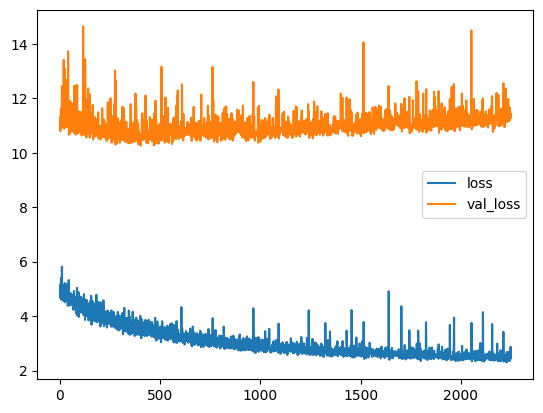

In [ ]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [ ]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [ ]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
